# **Data Exploration**

Distribusi kelas sebelum balancing: {'cp': 143, 'im': 77, 'imL': 2, 'imS': 2, 'imU': 35, 'om': 20, 'omL': 5, 'pp': 52}
Proporsi kelas sebelum balancing (%): {'cp': 42.56, 'im': 22.92, 'imL': 0.6, 'imS': 0.6, 'imU': 10.42, 'om': 5.95, 'omL': 1.49, 'pp': 15.48}


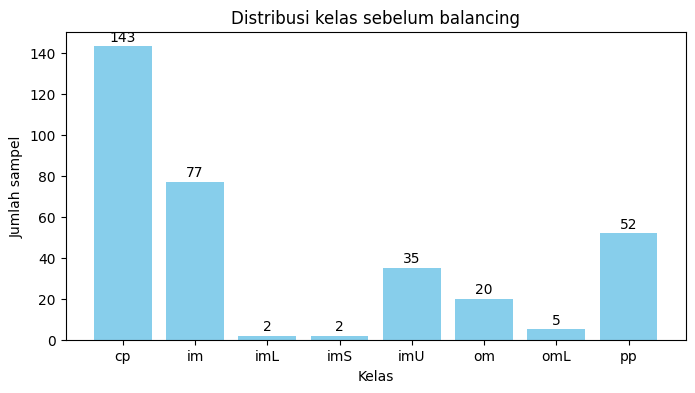

Distribusi kelas sesudah balancing (SMOTE): {'cp': 143, 'im': 143, 'imL': 143, 'imS': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}
Proporsi kelas sesudah balancing (%): {'cp': 12.5, 'im': 12.5, 'imL': 12.5, 'imS': 12.5, 'imU': 12.5, 'om': 12.5, 'omL': 12.5, 'pp': 12.5}


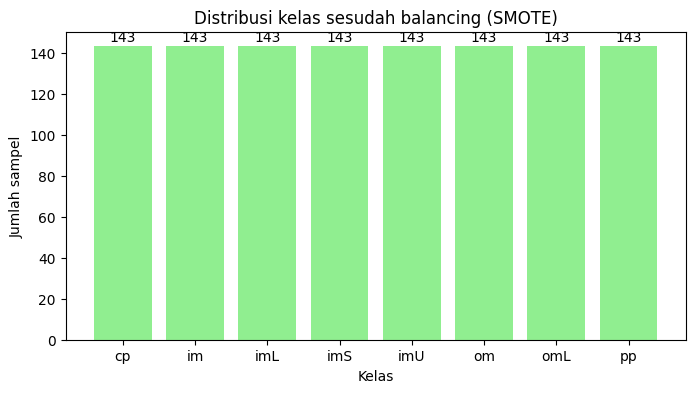

Akurasi Original: 0.7921
Akurasi SMOTE: 0.8198
ADASYN gagal dijalankan karena kelas minoritas terlalu sedikit.

=== Hasil Akurasi Naive Bayes ===
Original : 0.7920792079207921
SMOTE    : 0.8197674418604651
ADASYN   : None


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np

# === KONEKSI KE MYSQL ===
engine = create_engine("mysql+pymysql://root:@localhost/ecoli")
df = pd.read_sql("SELECT * FROM ecoli", engine)

# === PISAHKAN FITUR DAN LABEL ===
X = df[["feature1","feature2","feature3","feature4","feature5","feature6","feature7"]].values
y_raw = df["class_label"].values

# encode label
le = LabelEncoder()
y = le.fit_transform(y_raw)
target_names = le.classes_

# ==============================
# 🔹 1. Distribusi kelas sebelum balancing
# ==============================
unique, counts = np.unique(y, return_counts=True)
dist_before = dict(zip(le.inverse_transform(unique), counts))

print("Distribusi kelas sebelum balancing:", dist_before)

# proporsi (%)
total_before = sum(counts)
prop_before = {cls: round((cnt/total_before)*100, 2) for cls, cnt in dist_before.items()}
print("Proporsi kelas sebelum balancing (%):", prop_before)

# plot
plt.figure(figsize=(8,4))
bars = plt.bar(dist_before.keys(), dist_before.values(), color="skyblue")
plt.title("Distribusi kelas sebelum balancing")
plt.xlabel("Kelas")
plt.ylabel("Jumlah sampel")

# tambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha="center", va="bottom")
plt.show()

# ==============================
# 🔹 2. Balancing dengan SMOTE
# ==============================
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, y_smote = smote.fit_resample(X, y)

unique_s, counts_s = np.unique(y_smote, return_counts=True)
dist_after = dict(zip(le.inverse_transform(unique_s), counts_s))
prop_after = {cls: round((cnt/sum(counts_s))*100, 2) for cls, cnt in dist_after.items()}

print("Distribusi kelas sesudah balancing (SMOTE):", dist_after)
print("Proporsi kelas sesudah balancing (%):", prop_after)

# plot sesudah balancing
plt.figure(figsize=(8,4))
bars = plt.bar(dist_after.keys(), dist_after.values(), color="lightgreen")
plt.title("Distribusi kelas sesudah balancing (SMOTE)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah sampel")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha="center", va="bottom")
plt.show()

# ==============================
# 🔹 3. Modeling Naive Bayes
# ==============================
def naive_bayes_eval(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Akurasi {name}: {acc:.4f}")
    return acc

# sebelum balancing
acc_before = naive_bayes_eval(X, y, "Original")

# sesudah balancing SMOTE
acc_smote = naive_bayes_eval(X_smote, y_smote, "SMOTE")

# coba ADASYN (akan error kalau sampel minoritas <3)
try:
    adasyn = ADASYN(random_state=42, n_neighbors=1)
    X_ada, y_ada = adasyn.fit_resample(X, y)
    acc_adasyn = naive_bayes_eval(X_ada, y_ada, "ADASYN")
except Exception as e:
    print("ADASYN gagal dijalankan karena kelas minoritas terlalu sedikit.")
    acc_adasyn = None

# ==============================
# 🔹 4. Ringkasan Akurasi
# ==============================
print("\n=== Hasil Akurasi Naive Bayes ===")
print("Original :", acc_before)
print("SMOTE    :", acc_smote)
print("ADASYN   :", acc_adasyn)


## **Ringkasan hasil yang kamu dapat**

1. **Distribusi awal (sebelum balancing)**
- **{'cp':143, 'im':77, 'imL':2, 'imS':2, 'imU':35, 'om':20, 'omL':5, 'pp':52}**
- Proporsi (%) sebelum: **cp 42.56%, im 22.92%, imL 0.60%, imS 0.60%, imU 10.42%, om 5.95%, omL 1.49%, pp 15.48%.**

2. **Setelah SMOTE**
- Semua kelas menjadi 143 sampel → proporsi 12.5% per kelas (total 1144 sampel).

3. **Akurasi Naive Bayes**
- Original: 0.7921
- SMOTE (jalankan SMOTE lalu split): 0.8198
- ADASYN: gagal (kelas minoritas terlalu sedikit sehingga ADASYN tidak bisa membuat tetangga yang diperlukan).

**Sehingga :**
- SMOTE menambah sampel kelas minoritas sehingga model **(Naive Bayes)** memiliki lebih banyak contoh untuk belajar pola kelas minoritas, yaitu **mengurangi bias ke kelas mayoritas** lalu sering meningkatkan **metrik akurasi** atau **F1** untuk kelas minoritas.
- SMOTE yang diterapkan sebelum pemisahan train/test menyebabkan risiko data ***leakage***. Jika SMOTE dilakukan pada keseluruhan dataset lalu dibagi menjadi train/test, beberapa sampel sintetis yang dibuat dari kombinasi titik asli dapat masuk ke set uji (atau uji dapat memiliki sampel yang sangat mirip dengan yang dipakai untuk membuat training synthetic), sehingga performa pada test menjadi terlampau optimis. Karena itu, peningkatan akurasi dari 0.792 → 0.820 kemungkinan terpengaruh oleh kebocoran ini.